<h1 style="background-color:#E3F2FD; color:black; padding:10px; border-radius:8px;">
  BDA Competition 3: Human faces 
</h1>
<p style="font-size:20px; padding:10px; "> Group 8 </p> 

In [1]:
## Importing packages

library(tidyverse) # metapackage with lots of helpful functions
library(png) # package that can be used to read png image files in a simple format

## Reading in files
# Show the availabe directories
dirs = dir("../input", pattern="[^g]$", recursive=TRUE, include.dirs = TRUE, full.names = TRUE)
dirs

# Get all image files: file names ending ".png" 
anger   = dir(grep("anger",   dirs, value = TRUE), pattern = "png$", full.names = TRUE)
disgust = dir(grep("disgust", dirs, value = TRUE), pattern = "png$", full.names = TRUE)
happy   = dir(grep("happy",   dirs, value = TRUE), pattern = "png$", full.names = TRUE)
sad     = dir(grep("sad",     dirs, value = TRUE), pattern = "png$", full.names = TRUE)
test_im = dir(grep("test",    dirs, value = TRUE), pattern = "png$", full.names = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "../input/bda-2025-human-faces"                     
[2] "../input/bda-2025-human-faces/ckplus"              
[3] "../input/bda-2025-human-faces/ckplus/test"         
[4] "../input/bda-2025-human-faces/ckplus/train"        
[5] "../input/bda-2025-human-faces/ckplus/train/anger"  
[6] "../input/bda-2025-human-faces/ckplus/train/disgust"
[7] "../input/bda-2025-human-faces/ckplus/train/happy"  
[8] "../input/bda-2025-human-faces/ckplus/train/sadness"

# 1  Introduction
This competition concerns the classification of emotions based on images of human faces. The data are taken from an extension to the Cohn-Kanade database (CK+; Lucey et al., 2010), where images were cropped so the faces fit perfectly into the reference frame. Greyscale images were derived from videos of 101 participants who were asked to display different emotions. Class labels include anger, disgust, happiness and sadness as classified under the supervision of emotion researchers. The demographics are the following: Age: 8-50y, 69% female, 81% Euro-American, 13% Afro-American, and 6% other groups. Note that this also limits the generalisability of the performance of any classifier beyond this age group and to underrepresented ethnicities.

As this is a classification problem involving four classes, we can consider machine learning models that can classify into more than two classes. Options include multinomial regression, LDA, QDA, kNN, Naive Bayes, tree-based methods and support vector machines. Since the analysis based on raw pixels likely leads to many features, some feature selection is reasonable. This can be achieved through dimension reduction before model fitting (PCA) or using a model that performs feature selection (e.g., lasso regression).

Nugrahaeni and Mutijarsa (2016) assessed how machine learning algorithms perform when having to classify faces from the CK+ data base into seven categories: angry, disgust, fear, happy, neutral, sad and surprise. Using the largest data set, they reported accuracies of 98.85% for kNN and random forests. Human performance can be found below:

To get a sense of (a bound on) the Bayes error (i.e., the minimum accuracy we should aim for), it's helpful to consider the best "machine" we have for recognizing emotion from facial expressions: the human brain. How often do human judges get it right? In a study by [Mollahosseini et al. (2017)](https://arxiv.org/pdf/1708.03985), an estimate of human inter-rater agreement for classifying 11 emotions was provided. For the four emotions included in this data set, the agreement rates were:

| Disgust | Anger | Happy | Sad |
| --- | --- | --- | --- |
| 67.6% | 62.3% | 79.6% | 69.7% |

# 2  Importing Data
The images for this contest are

- grayscale, so we only need one *color channel 
- are only 48 by 48 pixels

Reading in images pixelwise is easiest: We simply store each image as a long vector of pixel intensities, row by row. Also we will need a vector that contains the emotion label for each of the images.

In [2]:
# Combine all filenames into a single vector
train_image_files = c(anger, happy, sad, disgust)

# Read in the images as pixel values (discarding color channels)
X = sapply(train_image_files, function(nm) c(readPNG(nm)[,,1])) %>% t()

# Create labels for the training images
y = c(rep("anger",   length(anger)),
      rep("happy",   length(happy)),
      rep("sad",     length(sad)),
      rep("disgust", length(disgust)))

# Process test images in the same way as the training images
X_test = sapply(test_im, function(nm) c(readPNG(nm)[,,1])) %>% t()

# Change row and column names of X to something more manageable (caret::train requires column names)
rownames(X)      = gsub(".+train/", "", rownames(X))
rownames(X_test) = gsub(".+test/",  "", rownames(X_test))

# Assign column names for X and X_test
colnames(X)      = paste("p", 1:ncol(X), sep = "")
colnames(X_test) = paste("p", 1:ncol(X_test), sep = "")

# Check the result (are X, X_test, and y what we expect?)
X[1:6, 20:23] %>% print()
table(y)
X_test[1:6, 20:23] %>% print()

                                    p20        p21        p22        p23
anger/S010_004_00000018a.png 0.58039216 0.60784314 0.70196078 0.85882353
anger/S010_004_00000018b.png 0.02745098 0.02745098 0.04313725 0.07450980
anger/S010_004_00000018c.png 0.03529412 0.03137255 0.02745098 0.01960784
anger/S010_004_00000018d.png 0.03921569 0.03137255 0.03137255 0.02745098
anger/S010_004_00000018e.png 1.00000000 1.00000000 1.00000000 1.00000000
anger/S010_004_00000018f.png 1.00000000 1.00000000 1.00000000 1.00000000


y
  anger disgust   happy     sad 
    570     744     870     354 

                              p20        p21        p22        p23
S010_004_00000017a.png 0.77647059 0.81960784 0.89803922 0.98039216
S010_004_00000017b.png 0.46666667 0.52549020 0.63529412 0.74901961
S010_004_00000017c.png 0.25490196 0.34509804 0.49803922 0.67450980
S010_004_00000017d.png 0.04313725 0.03529412 0.03529412 0.02745098
S010_004_00000017e.png 0.03921569 0.03137255 0.03137255 0.02745098
S010_004_00000017f.png 0.07058824 0.10588235 0.14509804 0.24705882


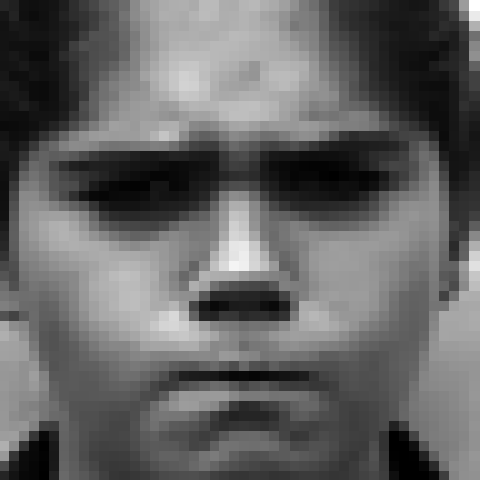

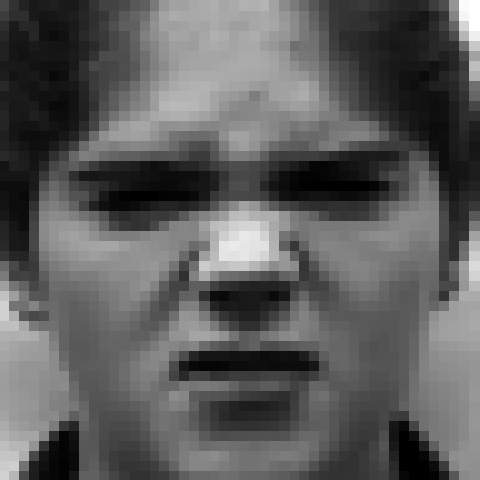

In [3]:
# Visualization utility function
as_image = function(x, nr=sqrt(length(x))) {opar=par(mar=rep(0,4)); on.exit(par(opar)); image(t(matrix(x,nr))[,nr:1], col = gray(0:255/255),axes=F)}

options(repr.plot.width=4, repr.plot.height=4)
as_image(X[13,])
as_image(X_test[13,])

# 3  Feature extraction 

## 3.1 Statistical features of raw pixels 

We defined a function to capture `entropy`, `power` and `lagged correlation` because there was no pre-defined function to obtian them using the packages allowed for this competiton. These features take single pixels as input and capture different aspects of the pixel intensity  within each image.


`Power` measures the overall pixel intensity from the image, where highe power reflects higher intensity/ brightness. 

`Lagged correlation` captures the similarity in pixel intenisty by comparing a pixel with its neighbouring pixels. This way it quantifies how smooth pixel values change across the face, where lowr values indicate changes in texture. 

`Entropy` measures the randomness or distribution of pixel intensities within an image, capturing how much texture or variation is present in a facial expression. For the images in our data set , higher or lower entropy values can reflect differences in facial muscles and contrast patterns specific for each emotion.

Other raw pixel features that we included are :

`Mean`: captures the average pixel intensity of the image, reflecting its overall brightness.

`Standard deviation`: measures the contrast or variability in pixel intensities; higher values indicate more variation across the face.

`Minimum / Maximum`:represent the darkest and brightest pixel values, providing simple measures of the image’s intensity range.

These did not require a pre-defined function because we were able to compute them from the base R backage that was available for the competiton. 

In [4]:
#entropy 
entropy <- function(x, nbreaks = nclass.Sturges(x)) { # function learned when studying (Grassman, 2018)
    r = range(x)
    x_binned = findInterval(x, seq(r[1], r[2], len= nbreaks))
    h = tabulate(x_binned, nbins = nbreaks) # fast histogram
    p = h/sum(h)
    -sum(p[p>0] * log(p[p>0]))
}

#power 
power <- function(x) {mean(x^2)}

#lagged correlation - inspired from group 11
lagged_cor = function(x, y=x, lag=0) {
    r_lagged = suppressWarnings(cor(x, lag(y, lag), use='pairwise.complete.obs'))
    return(r_lagged)}


Now we define the funciton `raw_pixel_features` that summarizes the raw pixel fetures for each pixel. 

In [5]:
raw_pixel_features <- function(img, lags = c(1, 2, 3)){
histogram_raw_features <-as_tibble(img)|>
    rowwise() |>
    summarize(
        #mean
        mean = mean(c_across(p1:p2304)),
        #Standard deviation 
        sd = sd(c_across(p1:p2304)),
        #minimum
        min = min(c_across(p1:p2304)),
        #maximum 
        max = max(c_across(p1:p2304)),
        #kurtosis
        kurtosis = e1071::kurtosis(c_across(p1:p2304), type = 3), #not sure if I can use this package
        
        #entropy
        entropy = entropy(c_across(p1:p2304)),
        #power
        power = power(c_across(p1:p2304)),
        
        #lagged correlation 
        lagged_cor_1 = lagged_cor(c_across(p1:p2304), lag = 1),
        lagged_cor_2 = lagged_cor(c_across(p1:p2304), lag = 2),
        lagged_cor_3 = lagged_cor(c_across(p1:p2304), lag = 3)
        
        
    )
return(histogram_raw_features)
}

## 3.2  Histogram features from edges

Histogram features work best on edges. How can you detect edges? To answer this question, we need to consider what an edge is: An edge is a rapid change in pixel intensities, so if we compute the difference between two consecutive pixels and check if it is greater than a certain threshold, we can find the pixels that are at the edge of an abrupt intensity change. In principle, this can be done in any direction (north, south, west, east, northwest, southwest, etc.), but it turns out that it is sufficient to do it in only two directions: north and west (or south and east, for that matter). These give horizontal and vertical edges, respectively. By calculating the differences in both the north and west directions consecutively, we filter out pixels that are part of a diagonal edge.

### 3.2.1  Function to extract edges
Below, I create a function (`get_edges`) that extracts edges from the pixels. The function takes the following arguments:
- `pixels`: a vector that contains the greyscale channel value for each pixel
- `dim`: a vector that specifies the number of rows and columns that correspond to the number of vertical and horizontal pixels of the underlying image
- `threshold`: the threshold for intensity change that needs to be exceeded so the pixel is considered an edge
    - if this argument is not supplied, the function assumes that the user would like the raw changes/gradients as an output
 
Output:
- a list with vertical and horizontal gradients

In [6]:
get_edges <- function(pixels, dim = c(48, 48), threshold) {
    # converting pixels to 48x48 matrix
    im <- matrix(pixels, nrow = dim[1], ncol = dim[2])

    # extract vertical (row-wise) and horizontal (column-wise) differences
    v_edge <- im[-1, ] - im[-nrow(im), ]
    h_edge <- im[, -1] - im[, -ncol(im)]

    # ==> START LLM src=https://chatgpt.com/share/68efb740-606c-8002-8e2b-b8ed516bd1c4
    # padding with 0 to make pooling possible later
    v_edge <- rbind(v_edge, 0)
    h_edge <- cbind(h_edge, 0)
    # ==> END LLM

    # if a threshold is provided, function returns differences
    # above that threshold (what about taking absolute value here)
    if(!missing(threshold)) {
        v_edge[v_edge < threshold] <- 0
        h_edge[h_edge < threshold] <- 0
    }

    # if no threshold is provided, function just returns the raw gradients in a list
    out <- list(
        "h" = h_edge,
        "v" = v_edge
    )
    return(out)    
}

### 3.2.2 Edge feature extraction
Next, we need to consider which features to derive from the gradients. Note that in the following section I will refer to "regions". I will explain what is meant by this when considering pooling below. The argumentation for the features applies to images as well as regions within images.

Statistical features are a good place to start:
- **Mean**: The average change can distinguish images/regions that overall have a large change into one, both or none of the directions (some emotions may exhibit a larger change into a particular direction than others).
- **SD**: The standard deviation quantifies the spread in differences/gradients: Are gradients very similar in magnitude or do they differ a lot across the image/region?
- **Cor**: The correlation indicates whether edges tend to have similar changes in both directions, very dissimilar changes or whether there is no relationship at all.
- **Average length of gradient vector**: Since we have changes in two directions that define a vector, we can compute the length of this vector: Are changes extreme in both directions or not?
- **Average gradient direction**: The arc-tangent is the angle between the x-axis and the vector from the origin to point defined by (x, y) ([see here](https://en.wikipedia.org/wiki/Atan2)). It gives an indication about the direction of the largest intensity change of the edge (gradient direction). The gradient direction is averaged per image/region.

The `edge_features` function below takes a list with the changes in horizontal and vertical direction as an input (see output of `get_edges` above) and outputs the features.

In [7]:
edge_features <- function(edges) {
    ## standard devitation
    sd_v <- sd(edges$v)
    sd_h <- sd(edges$h)

    ## mean
    mean_v <- mean(edges$v)
    mean_h <- mean(edges$h)

    ## correlation
    # if the sd of the gradients in any direction is 0,
    # the correlation is not defined
    # assign 0 in that case
    if (sd_v != 0 && sd_h != 0) {
        cor_v_h <- cor(as.numeric(edges$v), as.numeric(edges$h))
    } else {
        cor_v_h <- 0
    }

    ## average of sum of gradients in both directions
    sum_grad <- mean(sqrt(edges$v^2 + edges$h^2))

    # ==> START LLM src=https://chatgpt.com/share/68efb740-606c-8002-8e2b-b8ed516bd1c4
    ## angle between gradient vector and x-axis
    angle <- mean(atan2(edges$v, edges$h))
    # ==> END LLM
    
    out <- data.frame(sd_v, sd_h, mean_v, mean_h, cor_v_h, sum_grad, angle) 
    return(out)
}

### 3.2.3 HOG (Histogram of Oriented Gradients) features

The compute_hog function extracts gradient-based features by calculating how pixel intensities change horizontally and vertically across the image, then determining both the strength and direction of these changes at each pixel location. The image is divided into small patches, and within each patch the function creates a histogram that counts how many gradients point in different directions (binned into nine orientation categories from 0 to 180 degrees), with stronger gradients contributing more weight to their respective bins. These histograms from neighboring patches are then grouped and normalized together to reduce sensitivity to lighting variations.

The inclusion of HOG features considerably improved the model's performance, with the final polynomial SVM reaching a cross-validated accuracy of approximately 99.7% compared to substantially lower accuracies without these features. This improvement demonstrates that the HOG-derived features successfully capture the spatial patterns and edge orientations that are critical for distinguishing between the four emotion categories.

Source: We adopt the compute_hog function from Team 9’s notebook (Pajar, Stadnik, & Gesbert, 2025) (and they adapted the function used by group 5 fro the 2024 competiton), because their feature-engineering pipeline combining raw pixels, edges, and HOG—yielded strong cross-validated accuracy and placed highly on the course leaderboard. Reusing their HOG implementation keeps our baseline aligned with a proven approach while we focus our novelty on model selection and complementary features.

In [8]:
# HOG feature extractor
compute_hog <- function(input_image, target_size = NA, patch_size = 6) {
  # 1. Determine target image size
  if (is.na(target_size)) {
    target_size <- sqrt(length(input_image))
  }
  if (length(input_image) %% target_size != 0) stop("Invalid target size.")
  if (target_size %% patch_size != 0) stop("Invalid patch size.")
  
  # 2. Rescale image to 0–255 range (assuming input ∈ [0, 1])
  image_matrix <- matrix(input_image * 255, ncol = target_size, byrow = TRUE)
  
  # 3. Compute horizontal (x) and vertical (y) gradients using simple differencing
  x_borders <- cbind(0, image_matrix, 0)
  y_borders <- rbind(0, image_matrix, 0)
  
  gradient_x <- x_borders[, 3:(target_size + 2)] - x_borders[, 1:target_size]
  gradient_y <- y_borders[1:target_size, ] - y_borders[3:(target_size + 2), ]
  
  # 4. Compute gradient magnitude and orientation
  magnitude <- sqrt(gradient_x^2 + gradient_y^2)
  angle <- atan2(gradient_y, gradient_x) * (180 / pi)  # convert to degrees
  angle[angle < 0] <- angle[angle < 0] + 180           # range [0, 180)
  angle[angle == 180] <- 0
  
  # 5. Initialize histogram bins and block indices
  bins <- seq(0, 160, 20)  # 9 bins (0–180° in steps of 20°)
  blocks <- seq(1, target_size - patch_size, by = patch_size)
  all_histograms <- list()
  
  # 6. Loop through the cells (patches) and compute orientation histograms
  for (row_block in blocks) {
    for (col_block in blocks) {
      angle_block <- angle[row_block:(row_block + patch_size - 1),
                           col_block:(col_block + patch_size - 1)]
      magnitude_block <- magnitude[row_block:(row_block + patch_size - 1),
                                   col_block:(col_block + patch_size - 1)]
      angle_vec <- as.vector(angle_block)
      mag_vec <- as.vector(magnitude_block)
      
      hist_vec <- rep(0, 9)
      for (i in seq_along(angle_vec)) {
        a <- angle_vec[i]
        m <- mag_vec[i]
        if (a %in% bins) {
          hist_vec[bins == a] <- hist_vec[bins == a] + m
        } else {
          bin <- cut(a, bins, labels = FALSE)  # NB: values in (160,180) get dropped by this scheme
          if (!is.na(bin) && bin < 9) {
            w_right <- (a - bins[bin]) / 20
            w_left  <- 1 - w_right
            hist_vec[bin]     <- hist_vec[bin]     + w_left  * m
            hist_vec[bin + 1] <- hist_vec[bin + 1] + w_right * m
          }
        }
      }
      all_histograms[[length(all_histograms) + 1]] <- c(row_block, col_block, hist_vec)
    }
  }
  all_histograms <- do.call(rbind, all_histograms)
  
  # 7. Normalize across 2×2 cell blocks for contrast invariance
  output <- c()
  for (row_block in blocks[-length(blocks)]) {
    for (col_block in blocks[-length(blocks)]) {
      v <- c(
        all_histograms[all_histograms[,1] == row_block                 & all_histograms[,2] == col_block,                  3:11],
        all_histograms[all_histograms[,1] == row_block + patch_size    & all_histograms[,2] == col_block,                  3:11],
        all_histograms[all_histograms[,1] == row_block                 & all_histograms[,2] == col_block + patch_size,     3:11],
        all_histograms[all_histograms[,1] == row_block + patch_size    & all_histograms[,2] == col_block + patch_size,     3:11]
      )
      norm_v <- v / (sqrt(sum(v^2)) + 1e-6)
      output <- c(output, norm_v)
    }
  }
  return(output)
}

In [9]:
## Batch HOG for a matrix with one image per row
hog_features_batch <- function(img_matrix, target_size = 48, patch_size = 6) {
  feats <- lapply(seq_len(nrow(img_matrix)), function(i) {
    compute_hog(img_matrix[i, ], target_size = target_size, patch_size = patch_size)
  })
  M <- do.call(rbind, feats)
  rownames(M) <- rownames(img_matrix)
  colnames(M) <- paste0("hog_", seq_len(ncol(M)))
  as.data.frame(M)
}


## 3.3 Pooling
Computing these stastics or averaging values over the whole image loses a lot of information. Instead, we can specify a grid that splits the image into regions (e.g., a 3x3 grid delineating 9 regions). Now, we can compute these statistics within each of these regions and treat the values as separate features, thereby retaining more information. This is similar to a [pooling layer](https://en.wikipedia.org/wiki/Pooling_layer) in a neural network.

The `pool_image` function implements this idea taking a list with the changes in horizontal and vertical direction, and the grid dimensions as an input (see output of `get_edges` above) and outputting the features per region.

In [10]:
pool_image <- function(edge_list, grid_dim) {
    # ==> START LLM src=https://chatgpt.com/share/68efb740-606c-8002-8e2b-b8ed516bd1c4
    # number of rows and columns in the grid that is spanned over the image
    n_col <- grid_dim
    n_row <- grid_dim
    
    # how many rows/columns are in each of the regions
    row_size <- nrow(edge_list$v) / n_row
    col_size <- ncol(edge_list$v) / n_col

    # loop over the grid
    feat <- c()
    for (i in 1:n_row) {
        for (j in 1:n_col) {
            # obtain rows and columns included in each region
            r_start <- (i - 1) * row_size + 1
            r_end <- i * row_size
            c_start <- (j - 1) * col_size + 1
            c_end <- j * col_size

            # subset the edges to only include edges that are in the
            # relevant region
            sub <- list(
                v = edge_list$v[r_start:r_end, c_start:c_end],
                h = edge_list$h[r_start:r_end, c_start:c_end]
            )

            ## compute features
            features_sub <- edge_features(sub)

            # names that include the row and column of the region
            names(features_sub) <- paste(names(features_sub), i, j, sep = "_")

            # append to features
            feat <- c(feat, features_sub)  
        }
    }
    # ==> END LLM
    return(feat)
}

## 3.4  Putting it all together
The `extract_edge_features` function puts all this together using the following arguments:
- `img`: The dataframe/matrix with one row per image and columns indicating the intensity of the greyscale channel per pixel
- `pooling`: Boolean specifying whether pooling should be performed
- `threshold`: Threshold for intensity to be considered an edge
- `grid_dim`: Dimensions for the grid that specifies subregions over the image (needed for pooling)

Output:
- Dataframe with features (columns) per image (rows)

In [11]:
extract_edge_features <- function(img, pooling = TRUE, threshold = 0.0625, grid_dim = 6) {
    # obtain edges for each image by applying function across rows of the input
    edges <- apply(img, 1, get_edges, threshold = threshold)

    # if pooling should be performed, apply the pooling function to the edge matrices
    if (pooling) {  
        feat <- lapply(edges, pool_image, grid_dim = grid_dim)
    
    # else apply compute edge_features directly    
    } else {
        feat <- lapply(edges, edge_features)
    }

    # features are in a list with one entry per image
    # --> bind them into a dataframe
    feat <- do.call(rbind.data.frame, feat)
    
    # replacing NAs with 0s
    feat[is.na(feat)] <- 0 
    
    return(feat)
}

Let's compute the feature matrix. We compute the edge features once including pooling and once without to see if pooling has benefits.

In [12]:
# with pooling
X_edges_pool <- extract_edge_features(X, pooling = TRUE, threshold = 0.0625, grid_dim = 6)
head(X_edges_pool)

# without pooling
X_edges <- extract_edge_features(X, pooling = FALSE)

,sd_v_1_1,sd_h_1_1,mean_v_1_1,mean_h_1_1,cor_v_h_1_1,sum_grad_1_1,angle_1_1,sd_v_1_2,sd_h_1_2,mean_v_1_2,⋯,cor_v_h_6_5,sum_grad_6_5,angle_6_5,sd_v_6_6,sd_h_6_6,mean_v_6_6,mean_h_6_6,cor_v_h_6_6,sum_grad_6_6,angle_6_6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
anger/S010_004_00000018a.png,0.00000000,0.00000000,0.000000000,0.000000000,0.0000000,0.000000000,0.00000000,0.03935467,0.05270662,0.021017157,⋯,-0.05731134,0.02935049,0.02454369,0.1476954,0.04839593,0.07512255,0.01550245,0.58710553,0.07888095,0.3237527
anger/S010_004_00000018b.png,0.00000000,0.00000000,0.000000000,0.000000000,0.0000000,0.000000000,0.00000000,0.05104406,0.05232809,0.036948529,⋯,0.05430019,0.06736506,0.30238135,0.1027370,0.16711140,0.03639706,0.08020833,0.40854479,0.10131135,0.1167134
anger/S010_004_00000018c.png,0.01171207,0.04202724,0.002083333,0.015134804,0.2919905,0.016406851,0.02988143,0.04383538,0.05394119,0.026899510,⋯,0.28656796,0.10700210,0.28518962,0.1163220,0.07963764,0.04522059,0.02285539,0.07480669,0.06504308,0.2332575
anger/S010_004_00000018d.png,0.01272758,0.00000000,0.002267157,0.000000000,0.0000000,0.002267157,0.04908739,0.05169113,0.05180946,0.031250000,⋯,-0.09777672,0.03719363,0.09817477,0.1295423,0.13801173,0.06115196,0.06924020,0.35819305,0.11173940,0.2420370
anger/S010_004_00000018e.png,0.00000000,0.00000000,0.000000000,0.000000000,0.0000000,0.000000000,0.00000000,0.02932137,0.03997991,0.010784314,⋯,0.09191791,0.01637148,0.06570766,0.1372066,0.06325462,0.06917892,0.02401961,0.32513583,0.08389223,0.3371273
anger/S010_004_00000018f.png,0.00000000,0.01272758,0.000000000,0.002267157,0.0000000,0.002267157,0.00000000,0.02161094,0.03132972,0.005453431,⋯,-0.06153969,0.01587010,0.07363108,0.1383397,0.03890629,0.07524510,0.01182598,0.48913072,0.07877306,0.4097771


In [13]:
X_hog <- hog_features_batch(X)
head(X_hog)

,hog_1,hog_2,hog_3,hog_4,hog_5,hog_6,hog_7,hog_8,hog_9,hog_10,⋯,hog_1287,hog_1288,hog_1289,hog_1290,hog_1291,hog_1292,hog_1293,hog_1294,hog_1295,hog_1296
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
anger/S010_004_00000018a.png,0.018995465,0.012572983,0.0315582721,3.360819e-02,0.034867219,0.10006336,0.19122154,0.08536479,0.0088898176,0.01688335,⋯,0.096254916,0.0862355925,0.15829378,0.06954923,0.055389552,0.08055902,0.4353238,0.34963837,0.01410328,0.008554921
anger/S010_004_00000018b.png,0.002777724,0.002173640,0.0261184896,2.057105e-02,0.009115542,0.04546688,0.19405071,0.09639889,0.0271878886,0.01980184,⋯,0.047507647,0.0183758549,0.01311192,0.02664927,0.087270460,0.04893617,0.2899987,0.36394576,0.00000000,0.000000000
anger/S010_004_00000018c.png,0.017736182,0.012654453,0.0000000000,7.314822e-03,0.012295293,0.11466540,0.15242334,0.04537387,0.0263365323,0.00000000,⋯,0.071263024,0.3751626560,0.17521312,0.03203903,0.087687974,0.28101887,0.2991781,0.09865925,0.04431915,0.122751947
anger/S010_004_00000018d.png,0.687799426,0.019232958,0.1080029746,2.144240e-02,0.005886494,0.02184906,0.08184216,0.10627580,0.0042694209,0.56594018,⋯,0.063615961,0.0715419332,0.08355804,0.04182025,0.069182453,0.06688632,0.5351546,0.27145457,0.02019169,0.005558657
anger/S010_004_00000018e.png,0.571923862,0.003022367,0.0002237838,7.459459e-05,0.097638642,0.12004831,0.05040548,0.11505549,0.0003169154,0.75386097,⋯,0.003844789,0.0649664938,0.01381119,0.01576414,0.007040285,0.04665488,0.4165402,0.39221594,0.06989350,0.030216991
anger/S010_004_00000018f.png,0.438791985,0.018209575,0.0000000000,0.000000e+00,0.213643763,0.29289480,0.03825224,0.08907411,0.0051188415,0.64067915,⋯,0.020610293,0.0009165089,0.01079568,0.00000000,0.007846026,0.06267966,0.5709603,0.39172052,0.04434779,0.039487635


Extracting the raw pixel features from the train data images 

In [14]:
X_raw_feat <- raw_pixel_features(X)
head(X_raw_feat)

mean,sd,min,max,kurtosis,entropy,power,lagged_cor_1,lagged_cor_2,lagged_cor_3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3215448,0.2404281,0,1,-0.8222271,2.216904,0.1611717,0.8882774,0.7148159,0.5452845
0.3731516,0.2812963,0,1,-0.4151636,2.335219,0.2183353,0.8676020,0.7510293,0.6441012
0.3998434,0.2929819,0,1,-0.5815242,2.377792,0.2456759,0.8621583,0.6958267,0.5509541
0.3609154,0.2690661,0,1,-0.3756793,2.319689,0.2026251,0.8641297,0.7317867,0.6107756
0.3597086,0.2816508,0,1,-0.3859230,2.289782,0.2086831,0.7976902,0.5595046,0.4514234
0.3737371,0.2860984,0,1,-0.4878530,2.318352,0.2214962,0.8358785,0.6023286,0.4023826


In [15]:
# Combining into one feature matrix
X_comb_pool <- cbind(X_edges_pool, X_hog, X_raw_feat)
head(X_comb_pool)

X_comb <- cbind(X_edges, X_hog, X_raw_feat)

,sd_v_1_1,sd_h_1_1,mean_v_1_1,mean_h_1_1,cor_v_h_1_1,sum_grad_1_1,angle_1_1,sd_v_1_2,sd_h_1_2,mean_v_1_2,⋯,mean,sd,min,max,kurtosis,entropy,power,lagged_cor_1,lagged_cor_2,lagged_cor_3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
anger/S010_004_00000018a.png,0.00000000,0.00000000,0.000000000,0.000000000,0.0000000,0.000000000,0.00000000,0.03935467,0.05270662,0.021017157,⋯,0.3215448,0.2404281,0,1,-0.8222271,2.216904,0.1611717,0.8882774,0.7148159,0.5452845
anger/S010_004_00000018b.png,0.00000000,0.00000000,0.000000000,0.000000000,0.0000000,0.000000000,0.00000000,0.05104406,0.05232809,0.036948529,⋯,0.3731516,0.2812963,0,1,-0.4151636,2.335219,0.2183353,0.8676020,0.7510293,0.6441012
anger/S010_004_00000018c.png,0.01171207,0.04202724,0.002083333,0.015134804,0.2919905,0.016406851,0.02988143,0.04383538,0.05394119,0.026899510,⋯,0.3998434,0.2929819,0,1,-0.5815242,2.377792,0.2456759,0.8621583,0.6958267,0.5509541
anger/S010_004_00000018d.png,0.01272758,0.00000000,0.002267157,0.000000000,0.0000000,0.002267157,0.04908739,0.05169113,0.05180946,0.031250000,⋯,0.3609154,0.2690661,0,1,-0.3756793,2.319689,0.2026251,0.8641297,0.7317867,0.6107756
anger/S010_004_00000018e.png,0.00000000,0.00000000,0.000000000,0.000000000,0.0000000,0.000000000,0.00000000,0.02932137,0.03997991,0.010784314,⋯,0.3597086,0.2816508,0,1,-0.3859230,2.289782,0.2086831,0.7976902,0.5595046,0.4514234
anger/S010_004_00000018f.png,0.00000000,0.01272758,0.000000000,0.002267157,0.0000000,0.002267157,0.00000000,0.02161094,0.03132972,0.005453431,⋯,0.3737371,0.2860984,0,1,-0.4878530,2.318352,0.2214962,0.8358785,0.6023286,0.4023826


# 4 Model fitting 


We compared models of varying flexibility to find the one that offers the best accuracy while balancing underfitting and overfitting in line with the bias–variance trade-off.


We considered the following classifcation models: 

- Classification tree: a simple, interpretable model that recursively splits the data but can easily overfit
- random forest (RF): high flexibility ensemble of trees that reduces variance through averaging and random feature selection
- regularized multinomial regression: a linear model using elastic net regularization to control model complexity and prevent overfitting
- Suport vector machine (SVR): a margin-based classifier evaluated with linear, polynomial, and RBF kernels that is able to capture increasing levels of non-linearity


 We validated all models using 5-fold cross-validation, implemented via the 'trainControl()' function from the 'caret' package, which offers a robust estimate of model accuracy by averaging model performance across 5 data splits. 



In [16]:
suppressMessages(require(caret))

## Use multiple cores whenever possible
doMC::registerDoMC(cores = 4) 

set.seed(2023) # for repeatability (generally pick the seed randomly)
trCntrl = trainControl('cv', 5, allowParallel = TRUE)
tt <- Sys.time() # Measure execution time

## 4.1 Classification Tree

We will fit the classification tree twice: once with the edge features using pooling and once with the edge features computed without pooling. Note that we decided to include this comparison only for the classification tree because fitting all models twice would be too computationally expensive (and clutter the notebook). We will proceed with the features that show better cross-validation performance in the classification tree.

In [17]:
## Fit a CART using 5-fold cross-validation to tune the complexity parameter
# without pooling
fittree = train(x=X_comb, y=y, method='rpart', trControl = trCntrl, tuneGrid = data.frame(cp=.02))
fittree

## Report execution time
cat("\nExecution time: ", dur <- Sys.time() - tt, "\n")

CART 

2538 samples
1313 predictors
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2030, 2030, 2031, 2030, 2031 
Resampling results:

  Accuracy   Kappa    
  0.6469731  0.5059099

Tuning parameter 'cp' was held constant at a value of 0.02


Execution time:  10.37739 


In [18]:
# with pooling
fittree_pool = train(x=X_comb_pool, y=y, method='rpart', trControl = trCntrl, tuneGrid = data.frame(cp=.02))
fittree_pool

CART 

2538 samples
1558 predictors
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2030, 2030, 2030, 2032, 2030 
Resampling results:

  Accuracy   Kappa    
  0.6780788  0.5522347

Tuning parameter 'cp' was held constant at a value of 0.02

Let's compare the pooling model to the model without pooling.


Call:
summary.diff.resamples(object = diff(resamp))

p-value adjustment: bonferroni 
Upper diagonal: estimates of the difference
Lower diagonal: p-value for H0: difference = 0

Accuracy 
          CART     CART_pool
CART               -0.03111 
CART_pool 0.003186          

Kappa 
          CART     CART_pool
CART               -0.04632 
CART_pool 0.003004          


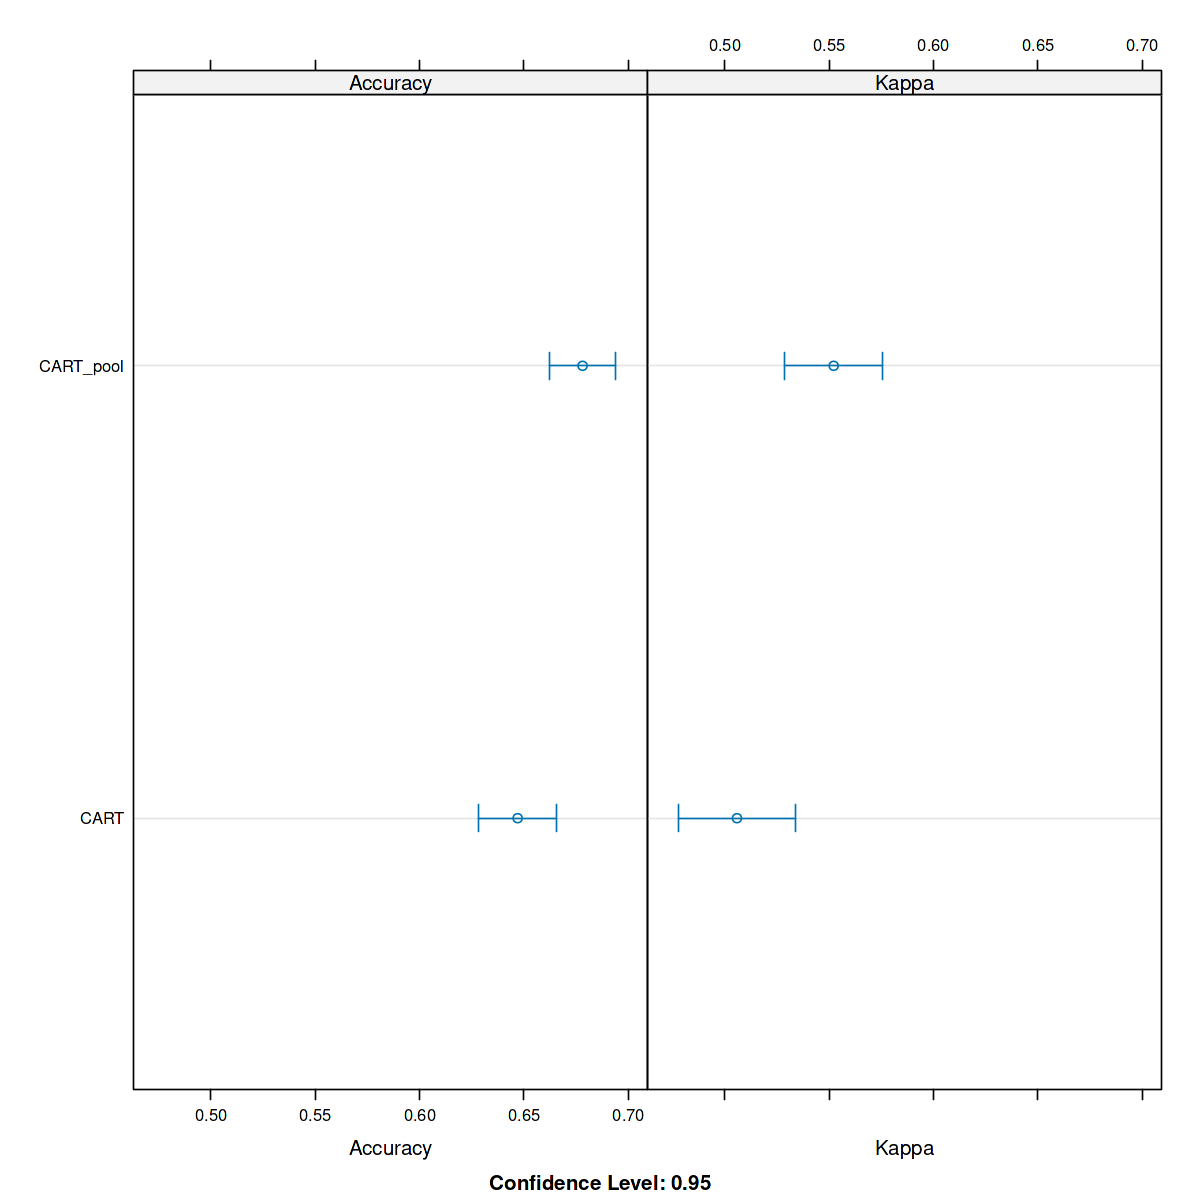

In [19]:
mod <- list(CART = fittree, CART_pool = fittree_pool)
resamp <- resamples(mod)
summary(diff(resamp))

## plot performance
options(repr.plot.width=10, repr.plot.height=10)
dotplot(resamp)

The classification tree with the edge features with pooling seems to perform better. Therefore, we will use the feature with pooling for the following models.
Crucially, the classification tree achieved an accuracy of only 0.69, performing moderately well at identifying the four emotion classes. This serves as a good starting point, but we believe that the model may not fully capture complex patterns in image features. We believe this issue will be at least partially solved my the following models we will fit.

In [20]:
## Check performance on training set
predtree = predict(fittree_pool, X_comb_pool, type='raw') 
confusionMatrix(predtree, factor(y))

Confusion Matrix and Statistics

          Reference
Prediction anger disgust happy sad
   anger     294      54     9  70
   disgust   163     585    52 147
   happy      90      82   803  21
   sad        23      23     6 116

Overall Statistics
                                          
               Accuracy : 0.7084          
                 95% CI : (0.6903, 0.7261)
    No Information Rate : 0.3428          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5888          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: anger Class: disgust Class: happy Class: sad
Sensitivity                0.5158         0.7863       0.9230    0.32768
Specificity                0.9324         0.7982       0.8843    0.97619
Pos Pred Value             0.6885         0.6177       0.8062    0.69048
Neg Pred Value             0.8693         0.9001  

## 4.2 Random forest

For Random forest (RF) models, a prediction is obtained by aggregating the results of all trees being aggregated, which greatly reduces variance compared to a single tree.
Flexibility for this model is high, as it combines many flexible base trees from which it learns, while maintaining stability through averaging.

In [21]:
library(ranger)

fit_rf <- train(X_comb_pool, y, method='ranger', 
    trControl = trCntrl, 
    tuneGrid = data.frame(mtry=9, splitrule="gini", min.node.size=10),
    importance = 'impurity'
)
fit_rf

Random Forest 

2538 samples
1558 predictors
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2031, 2030, 2030, 2031, 2030 
Resampling results:

  Accuracy   Kappa    
  0.9531077  0.9350883

Tuning parameter 'mtry' was held constant at a value of 9
Tuning
 parameter 'splitrule' was held constant at a value of gini
Tuning
 parameter 'min.node.size' was held constant at a value of 10

The Random Forest achieved a cross-validated accuracy of 0.95, indicating a substantial increase in accuracy from the performance of the single CART model.
This strong performance reflects the model’s ability to reduce variance and capture complex, non-linear relationships among features.


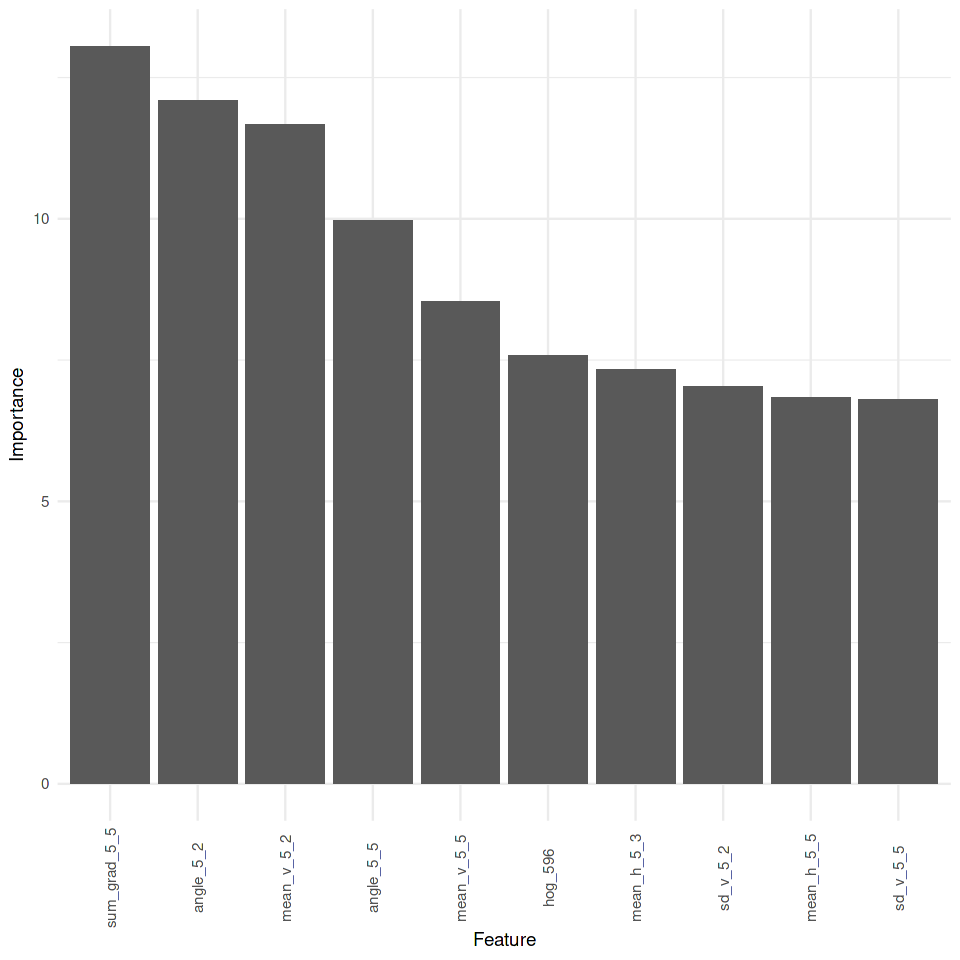

In [22]:
options(repr.plot.width=8, repr.plot.height=8)
## extract feature importance
imprt <- importance(fit_rf$finalModel) 

## plot importance values
tibble(Importance = imprt, Feature = names(imprt)) |> 
    arrange(-Importance) |>
    slice_head(n = 10) |> # filter 10 most important features
    # reorder the x-axis so features are plotted from most to least important
    ggplot(aes(y = Importance, x = reorder(Feature, -Importance))) +
    geom_col() + # bar plot
    theme_minimal() +
    # rotate x-axis labels
    theme(axis.text.x = element_text(angle = 90, vjust = .5)) + 
    labs(x = "Feature")

Most of the very important features are based on the 5th row of the grid. Let's make a plot that outlines the 5th row to investigate it further. 

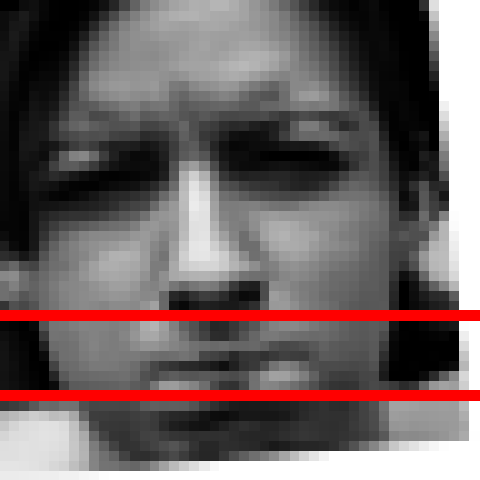

In [23]:
options(repr.plot.width=4, repr.plot.height=4)
# indices for the outlines of the row
ind1 <- (5 - 1) * 8
ind2 <- (6 - 1) * 8

# create matrix that contains 1s in the respective rows
# and 0s everywhere else
draw_mat <- matrix(0, nrow = 48, ncol = 48)
draw_mat[c(ind1, ind2), ] <- 1

# plot with sample image
as_image(X[3, ])
image(t(draw_mat)[, 48:1], col = c(NA, "red"), add = TRUE)


Perhaps unsurprisingly, the most important features are based on the row that includes the mouth, which is strongly associated with emotional expression. This provides valuable interpretability, showing that the model focuses on meaningful visual cues.

In [24]:
pred_rf <- predict(fit_rf, X_comb_pool, type='raw')
confusionMatrix(pred_rf, factor(y))

Confusion Matrix and Statistics

          Reference
Prediction anger disgust happy sad
   anger     570       0     0   0
   disgust     0     744     0   0
   happy       0       0   870   0
   sad         0       0     0 354

Overall Statistics
                                     
               Accuracy : 1          
                 95% CI : (0.9985, 1)
    No Information Rate : 0.3428     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         

Statistics by Class:

                     Class: anger Class: disgust Class: happy Class: sad
Sensitivity                1.0000         1.0000       1.0000     1.0000
Specificity                1.0000         1.0000       1.0000     1.0000
Pos Pred Value             1.0000         1.0000       1.0000     1.0000
Neg Pred Value             1.0000         1.0000       1.0000     1.0000
Prevalence            

The Random Forest achieved a perfect training accuracy of 1.00, meaning it correctly classified all samples in the training set.
This is a clear indication that the model is overfitting, meaning that the model may have memorized the training data rather than learned generalizable patterns. 

## 4.3 Regularised multinomial regression

In [25]:
suppressMessages(library(glmnet))

fit_mr = train(X_comb_pool, y, method='glmnet', 
    trControl = trCntrl
)
fit_mr

glmnet 

2538 samples
1558 predictors
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2031, 2030, 2031, 2030, 2030 
Resampling results across tuning parameters:

  alpha  lambda        Accuracy   Kappa    
  0.10   0.0006814878  0.9877836  0.9831820
  0.10   0.0068148781  0.9869962  0.9820965
  0.10   0.0681487809  0.9688712  0.9571317
  0.55   0.0006814878  0.9830530  0.9766753
  0.55   0.0068148781  0.9767515  0.9679919
  0.55   0.0681487809  0.8904673  0.8479758
  1.00   0.0006814878  0.9791137  0.9712533
  1.00   0.0068148781  0.9668996  0.9544364
  1.00   0.0681487809  0.8041777  0.7249941

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were alpha = 0.1 and lambda = 0.0006814878.

In [26]:
pred_mr <- predict(fit_mr, X_comb_pool, type='raw')
confusionMatrix(pred_mr, factor(y))

Confusion Matrix and Statistics

          Reference
Prediction anger disgust happy sad
   anger     570       0     0   0
   disgust     0     744     0   0
   happy       0       0   870   0
   sad         0       0     0 354

Overall Statistics
                                     
               Accuracy : 1          
                 95% CI : (0.9985, 1)
    No Information Rate : 0.3428     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         

Statistics by Class:

                     Class: anger Class: disgust Class: happy Class: sad
Sensitivity                1.0000         1.0000       1.0000     1.0000
Specificity                1.0000         1.0000       1.0000     1.0000
Pos Pred Value             1.0000         1.0000       1.0000     1.0000
Neg Pred Value             1.0000         1.0000       1.0000     1.0000
Prevalence            

The regularized multinomial regression model achieved a cross-validated accuracy of 0.99 and a training accuracy of 1 showing excellent fit on the training data.
Regularization (α = 0.1, λ ≈ 0.00068) effectively stabilized model coefficients while maintaining high predictive performance. Such high accuracy performance on the training set is alarming, as it indicates that the model may be overfitting. 

## 4.4 Support vector machine (SVM)

Support Vector Machines aim to find the hyperplane that maximizes the margin between classes, improving generalization. The choice of kernel function determines the model’s flexibility and ability to capture non-linear boundaries:

- Linear kernel: Low flexibility; works well for linearly separable data.
- Polynomial kernel: Moderate flexibility; captures polynomial relationships.
- Radial Basis Function  kernel: High flexibility; capable of modeling highly complex, non-linear boundaries.

We expect the SVM with polynomial kernel to perform particularly well in identifying the emotions in the sample images as this is known to be a top-performing method of image classification. 


In [27]:
## Linear kernel
fit_svm_linear <- train(
    X_comb_pool, 
    y, 
    method = 'svmLinear', 
    trControl = trCntrl
)
fit_svm_linear

Support Vector Machines with Linear Kernel 

2538 samples
1558 predictors
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2031, 2030, 2030, 2031, 2030 
Resampling results:

  Accuracy   Kappa    
  0.9905442  0.9869818

Tuning parameter 'C' was held constant at a value of 1

The linear SVM achieved a cross-validated accuracy of 0.99, showing strong and consistent classification performance across the four emotion classes.
This indicates that a simple linear boundary already captures much of the class separation in the data, suggesting that features are relatively well-structured.

In [28]:
## Polynomial kernel
fit_svm_poly <- train(
    X_comb_pool, 
    y, 
    method = 'svmPoly', 
    trControl = trCntrl
)
fit_svm_poly

Support Vector Machines with Polynomial Kernel 

2538 samples
1558 predictors
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2031, 2031, 2030, 2030, 2030 
Resampling results across tuning parameters:

  degree  scale  C     Accuracy   Kappa    
  1       0.001  0.25  0.9747876  0.9652609
  1       0.001  0.50  0.9795151  0.9717923
  1       0.001  1.00  0.9846348  0.9788439
  1       0.010  0.25  0.9885749  0.9842682
  1       0.010  0.50  0.9885757  0.9842700
  1       0.010  1.00  0.9885757  0.9842700
  1       0.100  0.25  0.9885757  0.9842700
  1       0.100  0.50  0.9885757  0.9842700
  1       0.100  1.00  0.9885757  0.9842700
  2       0.001  0.25  0.9944835  0.9924046
  2       0.001  0.50  0.9964536  0.9951176
  2       0.001  1.00  0.9964536  0.9951176
  2       0.010  0.25  0.9964536  0.9951180
  2       0.010  0.50  0.9964536  0.9951180
  2       0.010  1.00  0.9964536  0.9951180
  2       

The polynomial SVM achieved a cross-validated accuracy of 0.996 with the optimal parameters (degree = 3, scale = 0.001, C = 0.25).
This is a slight improvement over the performance of the model fit with a linear kernel, suggesting that introducing moderate non-linearity allows the model to better capture complex relationships between emotion classes. However, it is important to keep in mind that both models exhibit an extremely high performance. Therefore, it is difficult to even find differences between them, and they are likely overfitting the data.

In [29]:
## Radial kernel
fit_svm_rad <- train(
    X_comb_pool, 
    y, 
    method = 'svmRadial', 
    trControl = trCntrl
)
fit_svm_rad

Support Vector Machines with Radial Basis Function Kernel 

2538 samples
1558 predictors
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2030, 2030, 2032, 2030, 2030 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.25  0.9554745  0.9384611
  0.50  0.9806884  0.9733962
  1.00  0.9889624  0.9847999

Tuning parameter 'sigma' was held constant at a value of 0.0003452297
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.0003452297 and C = 1.

The radial SVM achieved a cross-validated accuracy of 0.99 with parameters C = 1 and σ = 0.0003.
This is comparable to the other SVMs.

# 5 Model comparison

To compare model performance, we summarized and visualized each algorithm’s cross-validated accuracy using descriptive statistics and comparison plots. The dot plot displays the mean accuracy and confidence intervals across resampling iterations, allowing us to assess performance accuracy. Pairwise difference plots were then used to test whether accuracy differences between models were statistically significant. The best model was selected as the one with the highest mean accuracy and non-overlapping confidence intervals, ensuring a robust comparison.


Call:
summary.resamples(object = resamp)

Models: RF, MR, tree, SVMlin, SVMpoly, SVMrad 
Number of resamples: 5 

Accuracy 
             Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
RF      0.9428008 0.9506903 0.9507874 0.9531077 0.9566929 0.9645669    0
MR      0.9842209 0.9861933 0.9862205 0.9877836 0.9881890 0.9940945    0
tree    0.6600791 0.6712598 0.6791339 0.6780788 0.6889764 0.6909449    0
SVMlin  0.9862205 0.9901381 0.9901575 0.9905442 0.9921105 0.9940945    0
SVMpoly 0.9921260 0.9960552 0.9960552 0.9964536 0.9980315 1.0000000    0
SVMrad  0.9822134 0.9881890 0.9881890 0.9889624 0.9921260 0.9940945    0

Kappa 
             Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
RF      0.9206359 0.9317418 0.9318808 0.9350883 0.9400950 0.9510880    0
MR      0.9782615 0.9810086 0.9810354 0.9831820 0.9837341 0.9918704    0
tree    0.5275597 0.5373406 0.5582326 0.5522347 0.5665365 0.5715038    0
SVMlin  0.9810180 0.9864190 0.9864519 0.9869818 0.9891443 0.9918

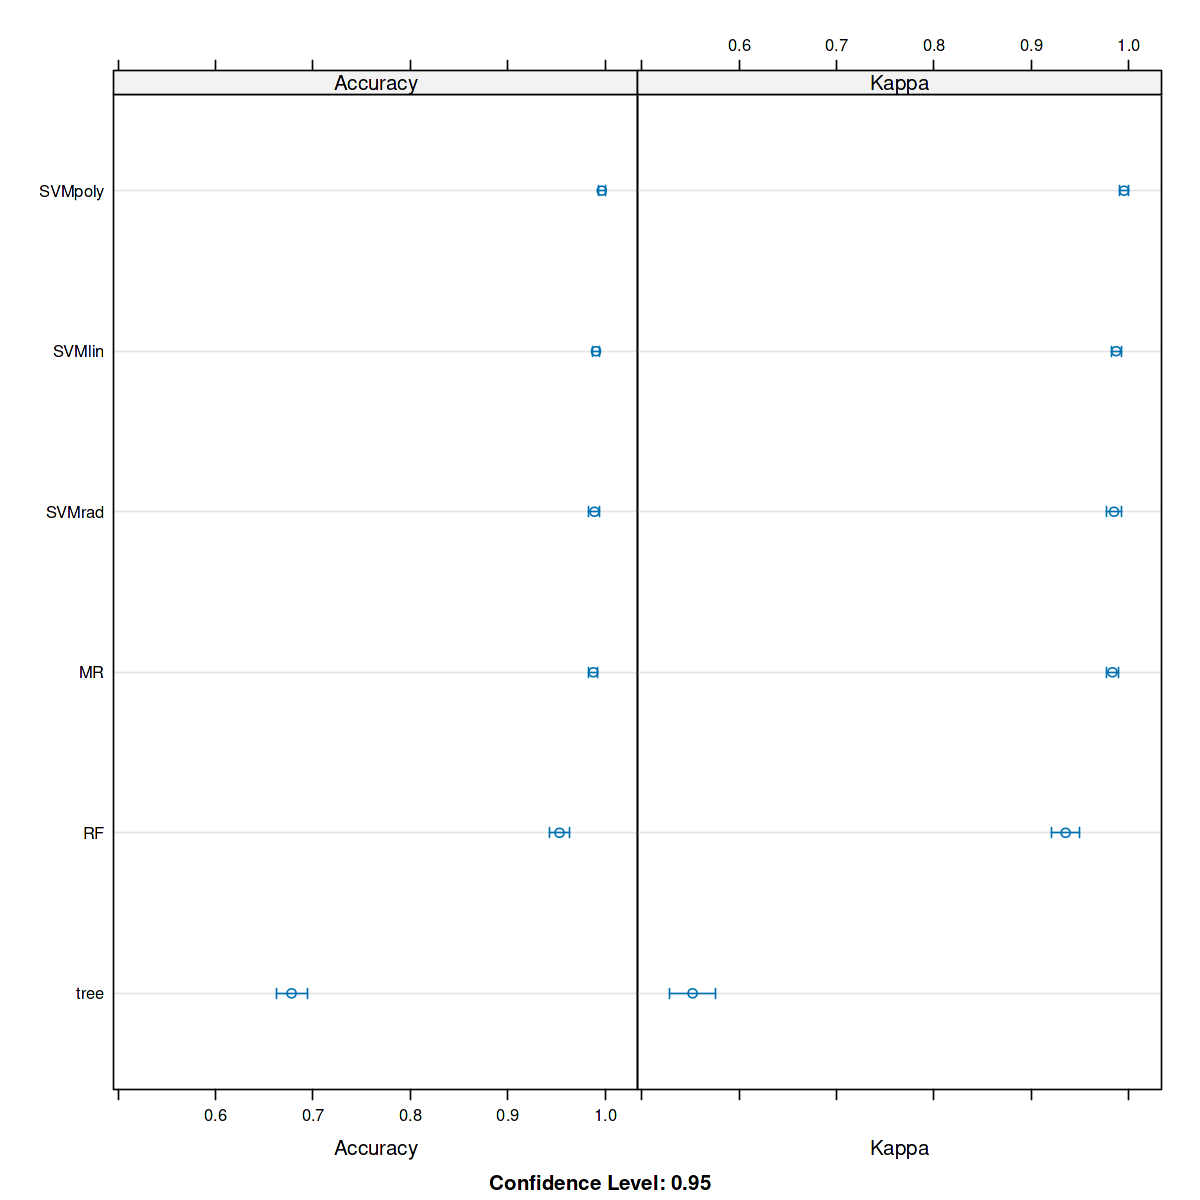

In [30]:
models <- list(
    RF = fit_rf, 
    MR = fit_mr,
    tree = fittree_pool,
    SVMlin = fit_svm_linear,
    SVMpoly = fit_svm_poly,
    SVMrad = fit_svm_rad
)
resamp <- resamples(models)
summary(resamp)

## plot for model performance
options(repr.plot.width=10, repr.plot.height=10)
dotplot(resamp)

Here we compare the cross-validated accuracy of all models, with confidence intervals showing variability across folds.
The SVM models (Polynomial, RBF, and Linear) and the Regularized Multinomial Regression achieved the highest mean accuracies, all above 0.98, demonstrating excellent performance and stability.
The Polynomial SVM performed best overall with a mean accuracy of approximately 0.996, indicating that introducing moderate non-linearity helped capture complex emotion patterns in the images.
The Random Forest also performed strongly (around 0.95), confirming that ensemble methods generalize well.
In contrast, the Classification Tree showed a much lower accuracy (around 0.67) and a wider confidence interval, reflecting higher variance and limited predictive capacity.
Overall, this figure highlights that increasing model flexibility improves accuracy, up to the point achieved by the Polynomial SVM.

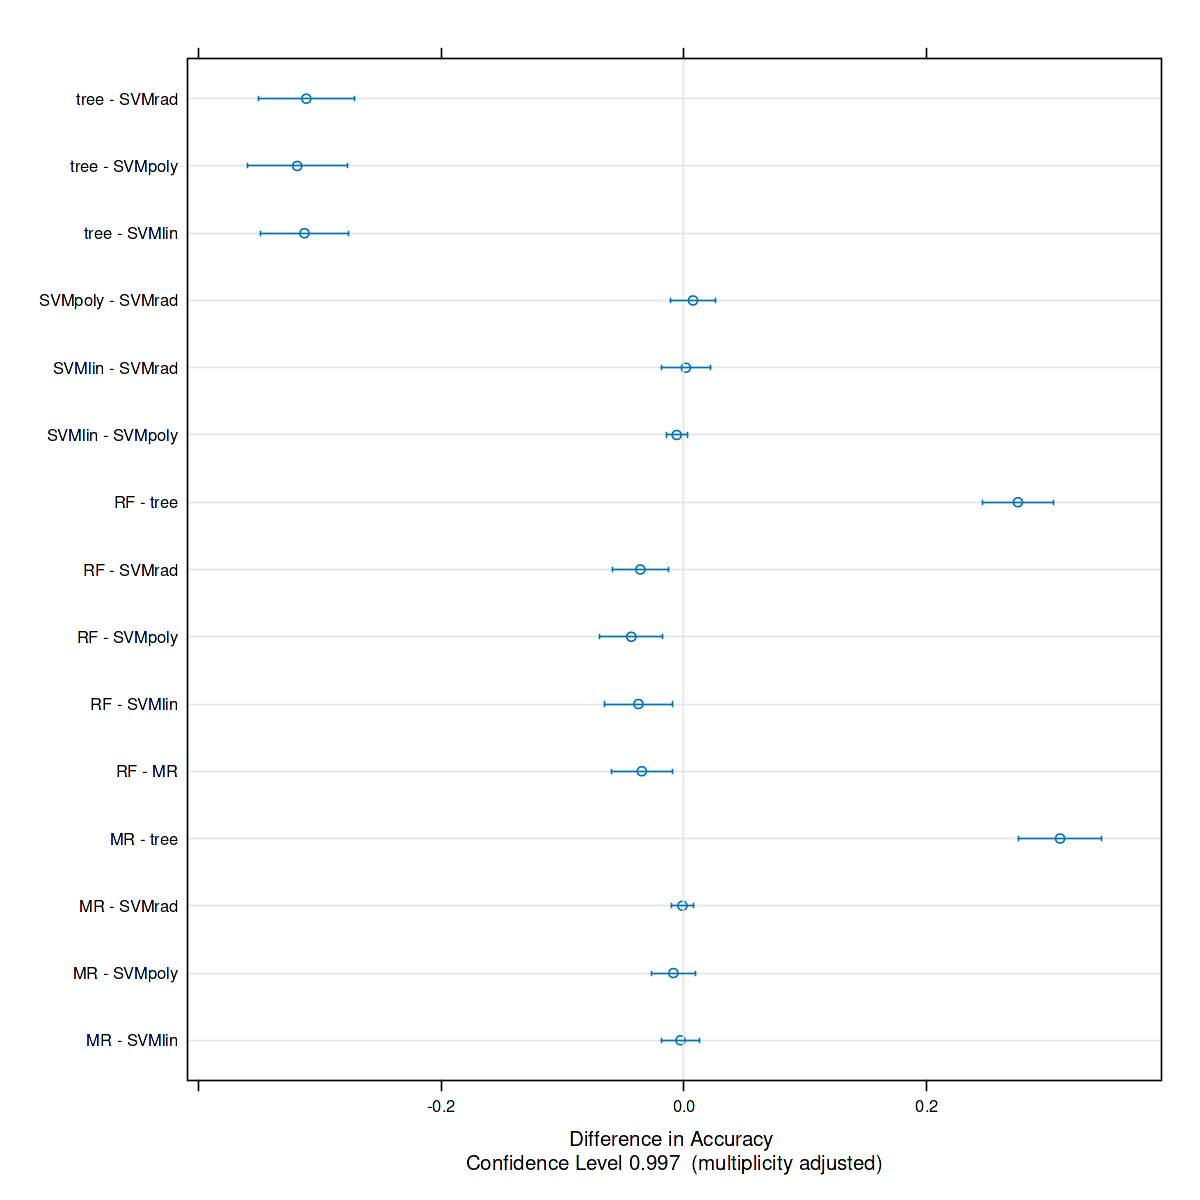

In [31]:
## plot for differences in model performance
options(repr.plot.width=10, repr.plot.height=10)
dotplot(diff(resamp))

This plot visualizes the pairwise differences in accuracy between models, with 99.7% confidence intervals adjusted for multiple comparisons.
If an interval crosses zero, the difference between two models is not statistically significant.
The best models — Polynomial SVM, RBF SVM, Linear SVM, and Regularized Regression — all have overlapping intervals, suggesting no significant performance difference between them.
However, all of these models outperform the Classification Tree by a clear margin, as seen in the intervals that fall far away from zero.
The Random Forest also consistently outperforms the tree but remains slightly below the best-performing SVM variants and the Regularized Regression.
This figure confirms that the Polynomial SVM achieves the highest mean accuracy, though the differences among the top models are within the expected sampling error range.

<p style="font-size:20px;">Conclusion </p>
Among all tested algorithms, the SVM models consistently achieved the highest validation accuracy and most stable results. Performance differences among the top models fell within the margin of error, and feature importance confirmed that the mouth region was most influential for emotion recognition. The Polynomial SVM in particular offered the best balance between flexibility and generalization, capturing non-linear relationships and performing well during CV. Given its strong and reliable performance, we selected the polynomial SVM as the final model for this task.

# 6 Formatting submission file

In [32]:
# compute features for test data
X_test_edge <- extract_edge_features(X_test, pooling = TRUE, threshold = 0.0625, grid_dim = 6)
X_test_hog <- hog_features_batch(X_test)
X_test_raw_feat <- raw_pixel_features(X_test)

In [33]:
X_test_feat <- cbind(X_test_edge, X_test_hog, X_test_raw_feat)
head(X_test_feat)

,sd_v_1_1,sd_h_1_1,mean_v_1_1,mean_h_1_1,cor_v_h_1_1,sum_grad_1_1,angle_1_1,sd_v_1_2,sd_h_1_2,mean_v_1_2,⋯,mean,sd,min,max,kurtosis,entropy,power,lagged_cor_1,lagged_cor_2,lagged_cor_3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S010_004_00000017a.png,0.000000000,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.03938722,0.05164876,0.02199755,⋯,0.3234426,0.2422453,0,1,-0.7631589,2.224219,0.1632724,0.8898196,0.7177280,0.5483408
S010_004_00000017b.png,0.000000000,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.03586225,0.05789069,0.01930147,⋯,0.3835257,0.2914196,0,1,-0.4970491,2.322106,0.2319805,0.8362590,0.6372736,0.4446959
S010_004_00000017c.png,0.000000000,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.03733626,0.03874794,0.01537990,⋯,0.3700112,0.2866906,0,1,-0.4193823,2.302683,0.2190641,0.8383072,0.6231901,0.4610430
S010_004_00000017d.png,0.000000000,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.05374714,0.05166707,0.03627451,⋯,0.3776093,0.2909685,0,1,-0.4559266,2.303955,0.2272147,0.8199698,0.7246774,0.6285538
S010_004_00000017e.png,0.008823529,0.03164371,0.001102941,0.01176471,-0.04721099,0.01286765,0.02454369,0.04843646,0.04556380,0.02659314,⋯,0.3959780,0.3039711,0,1,-0.6212742,2.331302,0.2491569,0.8593203,0.6654694,0.5110933
S010_004_00000017f.png,0.000000000,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.05389553,0.05621512,0.03492647,⋯,0.3589410,0.2653438,0,1,-0.4399136,2.319346,0.1992154,0.8462308,0.6557730,0.5129454


In [34]:
## Make predictions
predsvm_poly_test = predict(fit_svm_poly, X_test_feat, type='raw')

## Write to file
tibble(file = rownames(X_test), category = predsvm_poly_test) %>% 
    write_csv(file = "submission.csv")

## Check result
cat(readLines("submission.csv",n=20), sep="\n")

file,category
S010_004_00000017a.png,anger
S010_004_00000017b.png,anger
S010_004_00000017c.png,anger
S010_004_00000017d.png,anger
S010_004_00000017e.png,anger
S010_004_00000017f.png,anger
S011_002_00000022a.png,sad
S011_002_00000022b.png,sad
S011_002_00000022c.png,sad
S011_002_00000022d.png,sad
S011_002_00000022e.png,sad
S011_002_00000022f.png,sad
S011_005_00000018a.png,disgust
S011_005_00000018b.png,disgust
S011_005_00000018c.png,disgust
S011_005_00000018d.png,disgust
S011_005_00000018e.png,disgust
S011_005_00000018f.png,disgust
S011_006_00000013a.png,happy


# 7 References
Grasman, R. (2018). Feature Extraction From Signals. https://paper.dropbox.com/doc/Feature-extraction-from-Signals-qCp5uvj47gmyuw5nmB8lL

James, G., Witten, D., Hastie, T., Tibshirani, R., Taylor, J., & Bates, S. (2023). An introduction to statistical learning: With applications in R (2nd ed.). Springer. https://www.statlearning.com/

Nugrahaeni, R. A., & Mutijarsa, K. (2016). Comparative analysis of machine learning KNN, SVM, and random forests algorithm for facial expression classification. 2016 International Seminar on Application for Technology of Information and Communication (ISemantic), 163–168. https://doi.org/10.1109/ISEMANTIC.2016.7873831

Pajar, J., Stadnik, J., & Gesbert, S. (2025). Comp. 3 Facial Emotion Recognition – Group 9
[Kaggle notebook]. Kaggle. https://www.kaggle.com/code/jazminepajar/comp-3-facial-emotion-recognition-group-9

P. Lucey, J. F. Cohn, T. Kanade, J. Saragih, Z. Ambadar and I. Matthews (2010). The Extended Cohn-Kanade Dataset (CK+): A complete dataset for action unit and emotion-specified expression. IEEE Computer Society Conference on Computer Vision and Pattern Recognition - Workshops, San Francisco, CA, 2010, pp. 94-101, doi: 10.1109/CVPRW.2010.5543262.